## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from IPython.display import Audio, display
from typing import Tuple
from tqdm.auto import tqdm

import numpy as np
import torch
import whisper
import datasets

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP
from utils.whisper_hallucinations.dataloader import load_dataset

device = torch.device('mps')
sns.set_theme(context="paper", style="ticks")

/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation/lib/python3.10/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


## User input

## Load model

In [4]:
# Load the Whisper model
model = whisper.load_model("tiny")

## Load dataset

In [5]:
dataset_name = "ami_validation"

ds = load_dataset(dataset_name)

Found cached dataset ami (/Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5)
Loading cached processed dataset at /Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5/cache-76a34bc037fa70e6.arrow
Loading cached processed dataset at /Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5/cache-8c6e325cf1e5403b.arrow


In [6]:
# Fill `list_idx_hallucination` according to previous analysis:
list_idx_hallucination = [2387, 4329, 6645, 6687, 7167, 7991, 11595]

ds_hallucinations = ds.select(indices=list_idx_hallucination)

In [7]:
results = []
references = []
list_audio = []

for sample in tqdm(ds_hallucinations, total=ds_hallucinations.num_rows):
    results.append(model.transcribe(sample["audio"]["array"].astype(np.float32),
                                    language="en",
                                    temperature=0.0,
                                    no_speech_threshold=1.0,  # disable `no_speech_threshold`
                                    condition_on_previous_text=False,
                                    word_timestamps=True))
    references.append(sample["text"].lower())
    list_audio.append(sample["audio"])

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation/lib/python3.10/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation/lib/python3.10/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [8]:
from typing import Dict, Any

def count_overlaps(result: Dict[str, Any], return_freq: bool = False):
    list_words = []
    for segment in result["segments"]:
        list_words.extend(segment["words"])
    n_words = len(list_words)
    
    n_overlaps = 0
    for w1, w2 in zip(list_words, list_words[1:]):
        if w1["start"] == w1["end"] and w1["end"] >= w2["start"]:
            n_overlaps += 1
        elif w1["end"] > w2["start"]:
            n_overlaps += 1
    
    if return_freq:
        freq_overlaps = n_overlaps / n_words
        return n_overlaps, freq_overlaps
    else:
        return n_overlaps

In [9]:
n_overlaps, freq_overlaps = count_overlaps(results[1], return_freq=True)

print(n_overlaps, freq_overlaps)

0 0.0


In [10]:
overlaps = [count_overlaps(result) for result in results]

Reference:  mm
Prediction:   Thank you.

Number of overlaps: 0


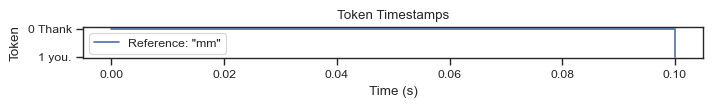

Reference:  yeah so uh what we'll do is uh
Prediction:   So, what we will do is,

Number of overlaps: 0


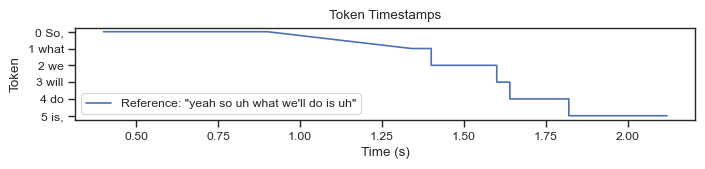

Reference:  um
Prediction:   Um...

Number of overlaps: 0


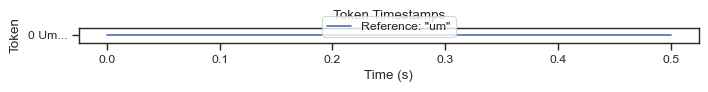

Reference:  yeah
Prediction:   Yeah.

Number of overlaps: 0


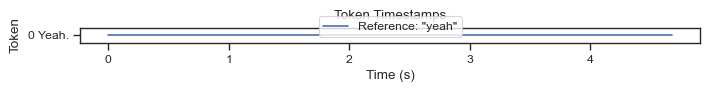

Reference:  s
Prediction:   Thanks.

Number of overlaps: 0


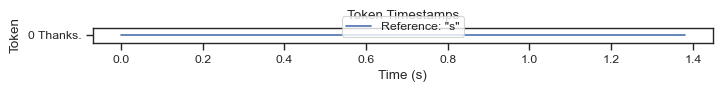

Reference:  yeah
Prediction:   you

Number of overlaps: 0


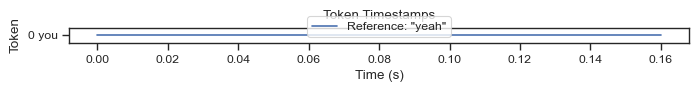

Reference:  d. a. w.
Prediction:   Day, a, w.

Number of overlaps: 0


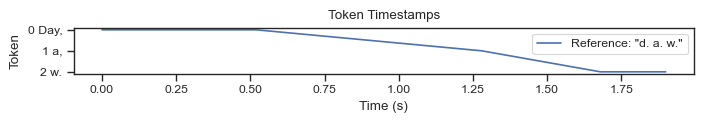

In [11]:
for audio, result, ref, n_overlaps in zip(list_audio, results, references, overlaps):
    # Load Audio player:
    display(Audio(data=audio["array"], rate=audio["sampling_rate"]))
    print
    
    # Print the transcribed text and word timestamps
    print("Reference: ", ref)
    print("Prediction: ", result["text"])
    print()
    
    # Print overlaps:
    print(f"Number of overlaps: {n_overlaps}")
     
    # Plot the token timestamps
    timestamps = []
    tokens = []
    counter = 0
    for segment in result["segments"]:
        for word in segment["words"]:
            timestamps.append(word["start"])
            timestamps.append(word["end"])
            tokens.append(str(counter) + word["word"])
            tokens.append(str(counter) + word["word"])
            counter += 1
    plt.figure(figsize=(8, len(tokens)*0.1))
    plt.plot(timestamps[::-1], tokens[::-1], label=f'Reference: "{ref}"')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Token")
    plt.title("Token Timestamps")
    plt.show()

## Tweak the hallucination figure

In [12]:
# Fill `list_idx_hallucination` according to previous analysis:
list_idx_hallucination = [223]

ds_hallucinations = ds.select(indices=list_idx_hallucination)

In [13]:
results = []
references = []
list_audio = []

for sample in tqdm(ds_hallucinations, total=ds_hallucinations.num_rows):
    results.append(model.transcribe(sample["audio"]["array"].astype(np.float32),
                                    language="en",
                                    temperature=0.0,
                                    word_timestamps=True))
    references.append(sample["text"].lower())
    list_audio.append(sample["audio"])

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
overlaps = [count_overlaps(result) for result in results]

In [15]:
for audio, result, ref, n_overlaps in zip(list_audio, results, references, overlaps):
    # Load Audio player:
    display(Audio(data=audio["array"], rate=audio["sampling_rate"]))
    print
    
    # Print the transcribed text and word timestamps
    print("Reference: ", ref)
    print("Prediction: ", result["text"])
    print()
    
    # Print overlaps:
    print(f"Number of overlaps: {n_overlaps}")
     
    # Plot the token timestamps
    timestamps = []
    tokens = []
    counter = 0
    for segment in result["segments"]:
        for word in segment["words"]:
            timestamps.append(word["start"])
            timestamps.append(word["end"])
            tokens.append(str(counter) + word["word"])
            tokens.append(str(counter) + word["word"])
            counter += 1

Reference:  yeah
Prediction:   Yeah.

Number of overlaps: 0


In [16]:
timestamps_truncated = timestamps[:30] + [timestamps[30]] + timestamps[-40:]
tokens_truncated = tokens[:30] + ["..."] + tokens[-40:]

IndexError: list index out of range

In [ ]:
plt.figure(figsize=(12, len(tokens_truncated)*0.1))
plt.plot(timestamps_truncated[::-1], tokens_truncated[::-1], label=f'Reference: "{ref}"')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Token")
plt.title("Token Timestamps")
plt.show()

## Consider audio blocks

In [ ]:
def count_overlaps(result: Dict[str, Any], stride: float = 0.) -> int:
    counter = 0
    list_words = []
    for segment in result["segments"]:
        list_words.extend(segment["words"])
    for w1, w2 in zip(list_words, list_words[1:]):
        if w1["end"] > w2["start"] - stride:
            counter += 1
    return counter

In [ ]:
count_overlaps(result, stride=0.01)